<a href="https://colab.research.google.com/github/sranga/UMass-AIML-Bootcamp/blob/main/Fake_News_Detection_Reproduction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Initial dataset shape: (44898, 5)
Train: 2000, Test: 500


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
wandb: Currently logged in as: sranga (sranga-personal) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.641100,0.608351,0.838000,0.787645,0.886957,0.834356


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


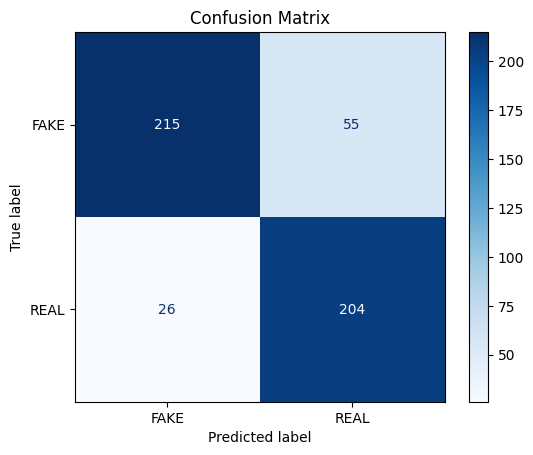

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Fast Tiny-BERT reproduction complete. Model, tokenizer, and results saved.


In [1]:
# ============================================
# Fast Tiny-BERT Fake News Detection
# Capstone Step 4 – Reproduction Experiments
# ============================================

# Upgrade and install dependencies
!pip install --upgrade -q transformers datasets torch evaluate scikit-learn matplotlib

# Load Dataset
import pandas as pd

df = pd.read_csv('fake_and_real_news.csv')
print("Initial dataset shape:", df.shape)

# Subsample for fast execution
train_df = df.sample(2000, random_state=42)
test_df = df.drop(train_df.index).sample(500, random_state=42)
print(f"Train: {len(train_df)}, Test: {len(test_df)}")

# Tokenization
from datasets import Dataset
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("prajjwal1/bert-tiny")

def tokenize_fn(batch):
    return tokenizer(batch['text'], truncation=True, padding='max_length', max_length=64)

train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

train_dataset = train_dataset.map(tokenize_fn, batched=True)
test_dataset = test_dataset.map(tokenize_fn, batched=True)

train_dataset = train_dataset.remove_columns(['text'])
test_dataset = test_dataset.remove_columns(['text'])
train_dataset.set_format('torch')
test_dataset.set_format('torch')

# Model Training
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

model = AutoModelForSequenceClassification.from_pretrained("prajjwal1/bert-tiny", num_labels=2)

training_args = TrainingArguments(
    output_dir='./results',
    eval_strategy='epoch',
    save_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=1,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=50,
    fp16=True
)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    return {
        'accuracy': accuracy_score(labels, preds),
        'precision': precision_score(labels, preds),
        'recall': recall_score(labels, preds),
        'f1': f1_score(labels, preds),
    }

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

trainer.train()

# Evaluation & Confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

preds = trainer.predict(test_dataset)
y_true = test_dataset['label']
y_pred = np.argmax(preds.predictions, axis=1)

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['FAKE','REAL'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Save Model & Results
model.save_pretrained('./fake_news_model_tiny')
tokenizer.save_pretrained('./fake_news_model_tiny')

results = trainer.evaluate()
with open('results_summary_tiny.txt','w') as f:
    f.write(str(results))

print("Fast Tiny-BERT reproduction complete. Model, tokenizer, and results saved.")
